<a href="https://colab.research.google.com/github/DanieloSendi/MachineLearning/blob/main/Lab11_Transformers_for_NLP_and_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Transformers, Vision Transformers**

Transformers networks are one of the latest inventions in the field of deep learning. First introduced in 2017 in the paper [“Attention is all you need”](https://arxiv.org/abs/1706.03762), they have dominated ever since. Originally, they were invented as a solution for various NLP tasks, such as classification, language translation, or image captioning - everything connected with text data or time series. Furthermore, in 2020 they were adapted for images too, where those so-called Vision Transformers easily outperformed other architectures. It is stated, that in the past two years (2020-2022) 70% of the papers in the field of deep learning mentioned transformers.

In this lab, we will run two simple transformer networks - one for text and another for image classification. However, keep in mind that classification is not the only task they excel at. In fact, they are mostly used in text-to-text or text-to-image conversion. In computer vision, they are also often used for bounding-box detection and task that required greater interpretability.


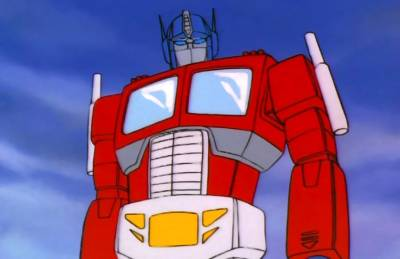

## Part 1 Original Transformers for NLP

### Introduction

Recurrent Neural Networks (RNN), which were covered last week are good at solving sequential data, but they face several problems. First of all, they can be slow to train, as they don't naturally work well with GPUs. Secondly, as they only have short-term memory, they fail to capture the meaning of more complex sentences.

For example, in the sentence *“The clouds are in the _ _ _.”* the next word should obviously be sky, as it is linked with the clouds. If the distance between clouds and the predicted word is short, so the RNN can predict it easily. However, in another example: *“I grew up in Germany with my parents, I spent many years there and have proper knowledge about their culture. That’s why I speak fluent _ _ _.”* the network might have a problem.

Both of these problems were partially solved by LSTM networks, but it was more like a group of hot-fix temporary solutions, rather than a complete shift in the network behaviour. Still, LSTMs process all the data sequentially and suffer from a vanishing gradient problem. LSTMs work for short text up to around 100 words, but their performance drops at around 1000 [1].

That's where transformers come into play. One of the good examples is that of a book. If we need specific information from a book we can read the whole book and come back with the answer (that's what RNNs do). We could also skip to the index, find the right chapter and just read the relevant information. What transformers networks try to do is focus our attention on specific parts of the data and analyse those.

After the traditional embedding, you learned about last week, the next step (specific to transformers) is positional encoding. In this layer, the network maps the relations between different words, by checking all the possible combinations between them. After this process, we have many vectors of different word combinations (known as context) that can then be fed into later layers and computed parallel on GPU.


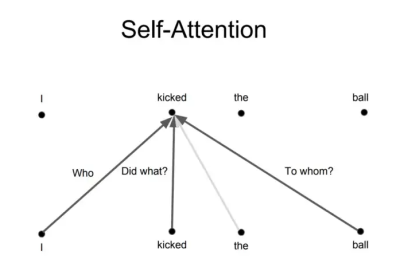


Those context vectors then go through a block called Multi-Head Attention. For every word, we calculate the correlation between other words. Because all words are usually correlated mostly with themselves, we repeat the process “from the point of view” of all the other words and average it. Thus, we create attention vectors for every single word.


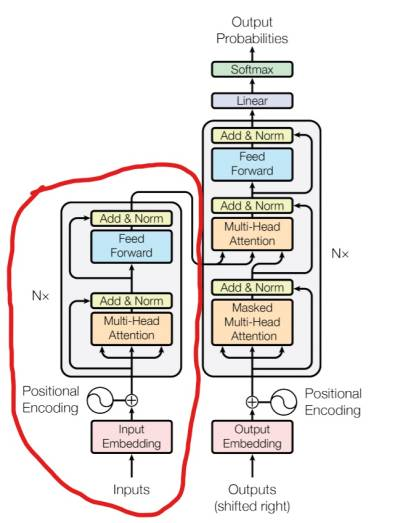


Attention vectors go into a feed-forward network (similar to RNN). Why is it faster than basic RNN? Because all the attention vectors are independent and can be computed parallel on GPU.

The part we described is marked in red in the image above. For classification that's all we need. However, when we perform complex tasks, like language translation, or other text-to-text mappings, we need to repeat the process for output texts and find relations between them.

If you want to read more explanation about how they work, check the websites below:

1. [Article 1](https://towardsdatascience.com/transformer-neural-network-step-by-step-breakdown-of-the-beast-b3e096dc857f)
2. [Article 2](https://towardsdatascience.com/transformers-141e32e69591)
3. [Article 3](https://blogs.nvidia.com/blog/what-is-a-transformer-model/)

### In practice

On this lab, we will only focus on the simplest classification task on a well-known dataset. Let's start by loading and preparing the IMDB data.


---


`MultipleHeadAttention layers were first introduced for tensorflow 2.4 version. It is recomended to have at least version 2.5. As our computers in the lab have tensorflow 2.0 you need to switch to Google Colab or work on your own laptop with the correct software installed.`


---



In [ ]:
# TODO Load imdb dataset from Keras
from tensorflow import keras
from keras.datasets import imdb
from keras.preprocessing import sequence

# TODO Only consider the top 20k words
vocab_size = 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size)

# Pad sequence to consider only the first 200 words of each movie review
maxlen = 200
print('Pad sequences (samples x time)')
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test =  keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('input_train shape:', x_train.shape)
print('input_test shape:', x_test.shape)

print(len(x_train), "Training sequences")
print(len(x_test), "Validation sequences")

17464789/17464789 [==============================] - 0s 0us/step
Pad sequences (samples x time)
input_train shape: (25000, 200)
input_test shape: (25000, 200)
25000 Training sequences
25000 Validation sequences


Define your own embedding module that does traditional embedding and positional encoding. Notice that it is basically the same method, but with a different length. Two seperate embedding layers, one for tokens, one for token index (positions).

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Implement transformers block using Keras MultiHeadAttention layer. Read carefully the call function and notice some weird connections. After calculating attention, it is added to the input (we use data + input, not the attention vectors only). Then, those data are fed into a simple feed-forward part (ffn), which in this simple example is mode from two dense layers.

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Define the network and run training. We use:

1. Prieviously defined embeding and positional encoding module
2. Transformer block
3. A few more dropout and dense layers as a final classifier (like before)

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed-forward network inside the transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x) #TODO add global average pooling
x = layers.Dropout(0.1)(x) #TODO add dropout
x = layers.Dense(20, activation="relu")(x) #TODO add dense layer with about 20 neurons
x = layers.Dropout(0.1)(x) #TODO add dropout

outputs = layers.Dense(2, activation="softmax")(x) #TODO add the final dense layer for classification

model = keras.Model(inputs=inputs, outputs=outputs)

Finally, we need to compile and fit the model. You can decide on the training hyperparameters yourself. You can validate the model on the test set, or do a separate split. It is up to you.

In [ ]:
#TODO Compile, fit and evaluate the model.
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_test, y_test))

model.evaluate(x_test, y_test)

Epoch 1/10
782/782 [==============================] - 74s 85ms/step - loss: 0.3861 - accuracy: 0.8143 - val_loss: 0.3067 - val_accuracy: 0.8719
Epoch 2/10
782/782 [==============================] - 29s 37ms/step - loss: 0.1994 - accuracy: 0.9243 - val_loss: 0.3209 - val_accuracy: 0.8690
Epoch 3/10
782/782 [==============================] - 14s 18ms/step - loss: 0.1314 - accuracy: 0.9530 - val_loss: 0.3584 - val_accuracy: 0.8636
Epoch 4/10
782/782 [==============================] - 14s 18ms/step - loss: 0.0870 - accuracy: 0.9710 - val_loss: 0.4654 - val_accuracy: 0.8567
Epoch 5/10
782/782 [==============================] - 16s 20ms/step - loss: 0.0593 - accuracy: 0.9808 - val_loss: 0.6274 - val_accuracy: 0.8442
Epoch 6/10
782/782 [==============================] - 11s 14ms/step - loss: 0.0418 - accuracy: 0.9869 - val_loss: 0.6800 - val_accuracy: 0.8352
Epoch 7/10
782/782 [==============================] - 12s 15ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.7417 - val_accuracy:

[0.980080246925354, 0.8373600244522095]

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

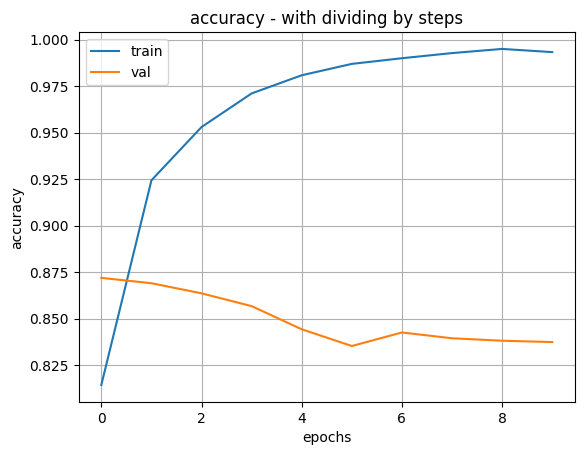

In [ ]:
# TODO: Plot the results
import matplotlib.pyplot as plt

# Extract values from the training history
training_loss = history_dict['accuracy']
validation_loss = history_dict['val_accuracy']

# Plot training and validation loss
plt.figure(1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('accuracy - with dividing by steps')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.grid()
plt.show()

Source: [Keras Documentation Examples](https://keras.io/examples/nlp/text_classification_with_transformer/)

For more advanced tasks, especially those with small datasets, there is also a possibility to use a pre-trained transformer. One of the most popular architectures is BERT (Bidirectional Encoder Representations from Transformers), which can be used for many different tasks. Some of BERT's features are already existing in Keras, but there are currently no pre-trained transformers available in `keras.applications`, like VGG. There is, however, a huge AI community called [Hugging Face](https://huggingface.co/), with a hundreds of pre-trained weights available for different types of transformers.

If you are interested in the topic of pre-training BERT models for various NLP tasks (or pre-training transformers in general), check the following tutorials:

- [Text Extraction With Bert](https://keras.io/examples/nlp/text_extraction_with_bert/)
- [Pretraining BERT](https://keras.io/examples/nlp/pretraining_BERT/)
- [Semantic Similarity with BERT](https://keras.io/examples/nlp/semantic_similarity_with_bert/)

## Part 2 Vision Transformers

### Introduction

In the famous paper ["An Image is Worth 16x16 Words"](https://arxiv.org/abs/2010.11929) the authors adapted transformers idea to a computer vision problems for the first time. The name Vision Transformer (ViT) refers to their original solution. However, for the next few years, many different modifications of it were proposed and pre-trained. In this lab, however, we will stick to the first one and use it for our well-known task of classification.

Wise men say that: *Transformers lack the inductive biases of Convolutional Neural Networks (CNNs), such as translation invariance and a locally restricted receptive field* [1]. To better explain that, we need to see how they work. The best way will be to notice similarities and differences between NLP transformers and vision ones.

Like in the classical transformers, the network tries to map the relationship between different parts of data and calculate the attention. But when the texts consisted of individual words that were easily separable, the images have to be converted into smaller patches:

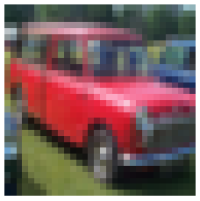


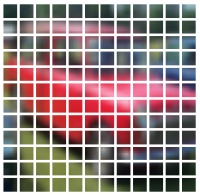

Those patches are then mapped with a positional embedding and multiple head attention blocks just like text data. The final feature vectors are processed by simple multiple-layer perceptron and used for classification.

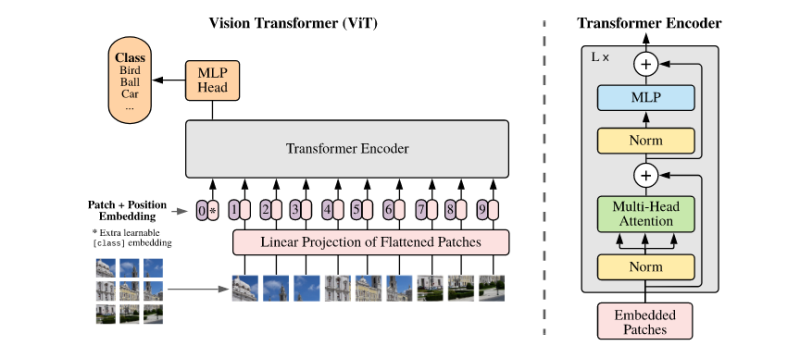

One of the benefits of transformers is that they are easily interpretable. Their basic structure is based on attention mechanisms (like GradCAM, SaliencyMaps etc.), so they already have it calculated. Not only can we easily extract those values as heatmaps interpretable for the human eye. We are already sure that the network focuses on the correct regions - after all, it started by choosing the right patch.

Furthermore, as we mentioned in the beginning, transformers look at the whole image and map the relations, instead of focusing on the small neighbourhood like the CNNs. It is also more intuitive than the CNNs hierarchical representation. In fact, this is what humans do. We first look at the whole image and focus on the most interesting region.

You can read more about ViTs in the following articles:

1. [Article 1](https://towardsdatascience.com/what-are-vision-transformers-and-how-are-they-important-for-general-purpose-learning-edd008545e9e)
2. [Article 2](https://theaisummer.com/vision-transformer/)

### Implementation

There are many ways to replicate the oryginal Vision Transformer in Keras or pyTorch and train it from scratch. You will find many tutorials that can help you explain the details of the architectures. A very good one can be found in [Keras Documentation Example](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

We can, however, also use an already pre-trained vision transformer according to a transfer learning methodology. Many vision models are available in the hugging face library we mentioned before. It is the best way to work with transformers if you are working in PyTorch. On the other hand, in Keras, you can try `vit_keras` library, which is the easiest way to do transfer learning. It also has some usefull tools for visualising attention for interpretability.

Let's start by installing `vit_keras`. Another usefull library might be `tensorflow-addons`.

In [ ]:
!pip install --quiet vit-keras
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.1 MB/s eta 0:00:00


Use your knowledge from all previous tasks to solve a simple classification problem with transfer learning from pre-trained vision transformer. You can use dogs and cats or any other dataset. Invent your own top layers (any combination of `Dense`, `Flatten`, `Dropout`, `BatchNormalisation` etc.). ViT model can be imported as below. There are four models available (B16, B32, L16, L32) that use different patch size and different number of layers. Use whichever you find best.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Resizing, Input
from vit_keras import vit, visualize, utils

# Load and preprocess dataset (CIFAR-10)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalizing the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Converting labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
# Set up the ViT model
vit_model = vit.vit_b32(image_size=224,
                        activation='linear',  # 'linear' because we add custom layers later, softmax, sigmoid, etc. does not matter if you are not including top
                        pretrained=True,
                        include_top=False,
                        pretrained_top=False,
                        classes=10)

# Create model using functional API
input_shape = x_train.shape[1:]  # Shape of CIFAR-10 images
inputs = Input(shape=input_shape)

# Resize images to match ViT input size
resized_images = Resizing(224, 224, interpolation="bilinear")(inputs)

# Get ViT features
vit_features = vit_model(resized_images)

# Add custom layers on top
flattened = Flatten()(vit_features)
dense1 = Dense(1024, activation='relu')(flattened)
dropout = Dropout(0.5)(dense1)
batchnorm = BatchNormalization()(dropout)
outputs = Dense(10, activation='softmax')(batchnorm)  # Multiclass classification

# Create the model
model2 = Model(inputs=inputs, outputs=outputs)

353253686/353253686 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096  

In [ ]:
# Compile and fit the model.
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(x_train, y_train,
                      batch_size=32,
                      epochs=10,
                      validation_data=(x_test, y_test))

Epoch 1/10
  86/1563 [>.............................] - ETA: 7:02:44 - loss: 2.6610 - accuracy: 0.1148

KeyboardInterrupt: 

In [ ]:
history_dict = history2.history
history_dict.keys()

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.show()

After finishing training, it is a good idea to try some interpretability. Vision transformers, unlike convolutions, do not really work well with tools such as GradCam. Instead, they have their own attention mechanisms, that are already done in their first layers - multi-head attention. We can use them to visualise which patches are the most important. In `vit_keras` library, you can use `visualize` funtion to do that.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from vit_keras import visualize

def visualize_attention_map(model, image):
    # Preprocess and predict
    preprocessed_image = preprocess_image(image)
    attention_layer_index = 5  # Assuming the attention layer is at index 5, modify if needed
    attention_map = visualize.attention_map(model=model2, image=preprocessed_image, layer_index=attention_layer_index)

    # Display original image and attention heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(image)
    ax2.imshow(attention_map, cmap='jet', alpha=0.5)  # Overlay the heatmap
    ax2.set_title('Attention Map')
    ax2.axis('off')

    plt.show()

# Select an image from CIFAR-10 test set
sample_image = x_test[0]  # Replace 0 with another index if you want to test a different image

# Visualize attention map
visualize_attention_map(model2, sample_image)

# Attention map will be an oryginal image with some areas darker and some lighter.
# if you want to create a proper heatmap, you will need to manually apply a colormap.

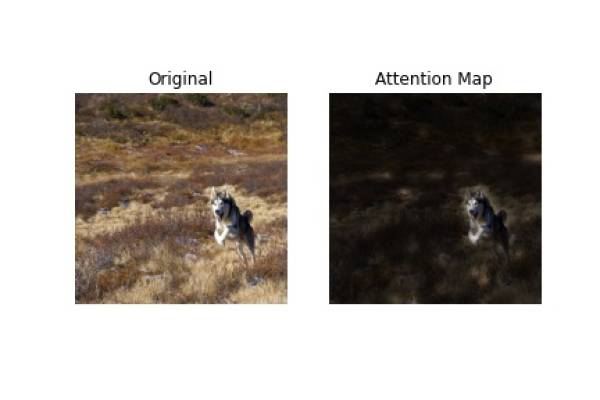

If you need help with funtions from `vit_keras`, you can check the [documentation here](https://github.com/faustomorales/vit-keras).

You have now learned how to use ViTs for classification. Like in NLP, we can use Vision Transformers for many different tasks. While segmentation methods are not yet that well explained and described, for classification and detection there are many pre-trained models and great tutorials. You can find some of them on Keras website:

- [Detection](https://keras.io/examples/vision/object_detection_using_vision_transformer/)
- [Video](https://keras.io/examples/vision/vivit/)
- [Tokenization](https://keras.io/examples/vision/vivit/)
- [Transfer Learning](https://keras.io/examples/vision/vivit/)

Finally, after all this praise in the beginning of this instruction, it is worth mentioning that transformers `require a very large amount of data to beat CNNs`. If you don't have those, it is probably better to stick to basic CNNs or even better, use a pre-trained CNN or transformer according to transfer learning methodology.